# BERT


In [1]:
import os
import math
import re
import collections
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader, TensorDataset
from model.playDL import *

## Masking Input

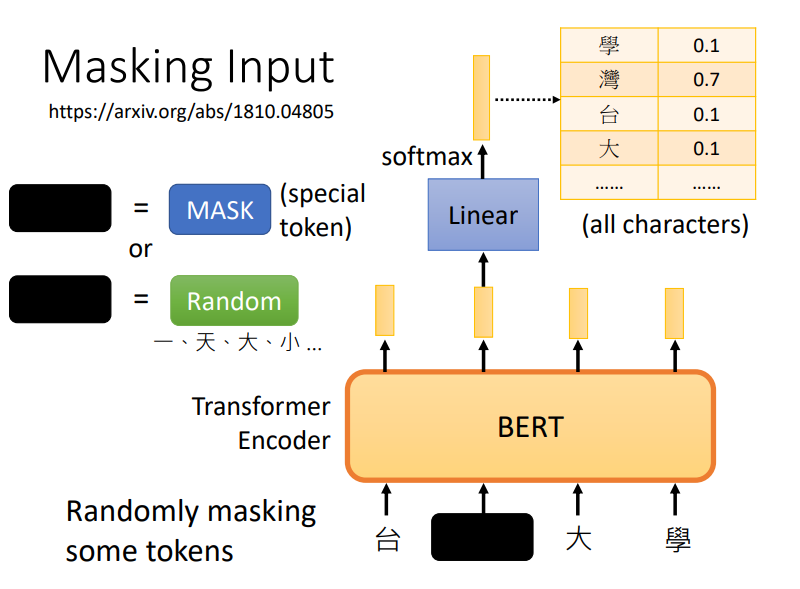

BERT选择Transformer编码器作为其双向架构。在Transformer编码器中常⻅是，位置嵌⼊被加⼊到输⼊序
列的每个位置。然⽽，与原始的Transformer编码器不同，BERT使⽤可学习的位置嵌⼊。

In [2]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输⼊序列的词元及其⽚段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记⽚段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

In [3]:
get_tokens_and_segments(['a', 'dsf'])

(['<cls>', 'a', 'dsf', '<sep>'], [0, 0, 0, 0])

In [4]:
class BERTEncoder(nn.Module):
    '''BERT 编码器'''
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, num_layers, dropout,
                max_len=1000, key_size=768, query_size=768, value_size=768,
                **kwargs):
        super().__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量⼤⼩，最⼤序列⻓度，num_hiddens）
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, num_heads, num_layers, dropout)

In [6]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

In [7]:
class MaskLM(nn.Module):
    """BERT的掩蔽语⾔模型任务"""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super().__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.LayerNorm(num_hiddens),
                    nn.Linear(num_hiddens, vocab_size))
        
    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [8]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [9]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [10]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

## Next Sentence Prediction

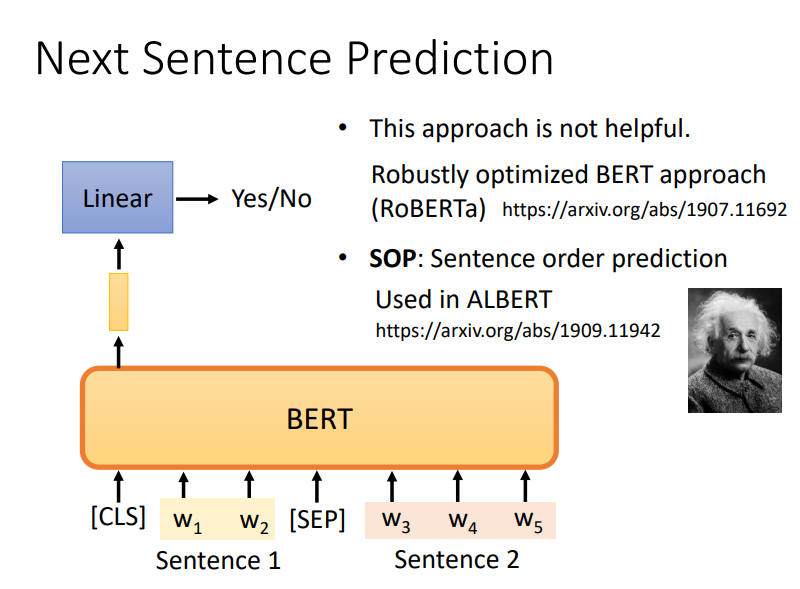

尽管掩蔽语⾔建模能够编码双向上下⽂来表⽰单词，但它不能显式地建模⽂本对之间的逻辑关系。为了帮助理解两个⽂本序列之间的关系，BERT在预训练中考虑了⼀个⼆元分类任务——下⼀句预测。在为预训练⽣成句⼦对时，有⼀半的时间它们确实是标签为“真”的连续句⼦；在另⼀半的时间⾥，第⼆个句⼦是从语料库中随机抽取的，标记为“假”。

判断sentence1和sentence2有没有接在一起。

In [11]:
class NextSentencePred(nn.Module):
    """BERT的下⼀句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super().__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)
    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

In [12]:
encoded_X.shape

torch.Size([2, 8, 768])

In [13]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输⼊形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [14]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [15]:
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, num_heads, num_layers, dropout,
                max_len=1000, key_size=768, query_size=768, value_size=768,
                hid_in_features=768, mlm_in_features=768,
                nsp_in_features=768):
        super().__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                                ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                                dropout, max_len=max_len, key_size=key_size,
                                query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)
        
    def forward(self, tokens, segments, valid_lens=None,
                pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # ⽤于下⼀句预测的多层感知机分类器的隐藏层，0是“<cls>”标记的索引
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

In [16]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
net = BERTModel(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                    ffn_num_hiddens, num_heads, num_layers, dropout)

In [17]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
encoded_X, mlm_Y_hat, nsp_Y_hat = net(tokens, segments, None, mlm_positions)
encoded_X.shape, mlm_Y_hat.shape, nsp_Y_hat.shape

(torch.Size([2, 8, 768]), torch.Size([2, 3, 10000]), torch.Size([2, 2]))